# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import math
import circle_fit as cf
from PIL import Image
from IPython.display import clear_output
%matplotlib inline

In [2]:
import SOMacc  #Use only SOM if numba not installed 

# Imports for Unet

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, Conv2DTranspose, Activation, Conv2D, MaxPooling2D

2023-07-12 12:44:13.039836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 12:44:13.531853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Unet Model for Particle Positioning

In [4]:
visible = Input(shape=(None,None,1))
conv1 = Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")(conv1)
conv2 = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2),strides=2, padding="same")(conv2)
conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")(conv3)
conv4 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu')(pool3)
conv5 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu')(conv4)
transp1 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None)(conv5)
merge1 = concatenate([transp1, conv3], axis=-1)
conv6 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu')(merge1)
transp2 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None)(conv6)
merge2 = concatenate([transp2, conv2], axis=-1)
conv7 = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu')(merge2)
transp3 = Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None)(conv7)
merge3 = concatenate([transp3, conv1], axis=-1)
conv8 = Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu')(merge3)
conv9 = Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu')(conv8)
conv10 = Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu')(conv9)
conv11 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation='sigmoid')(conv10)

model = Model(inputs=visible, outputs=conv11)
model.summary()

model.load_weights('normal_model_weights.h5')

2023-07-12 12:44:14.273874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-12 12:44:14.298770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-12 12:44:14.298822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-12 12:44:14.301188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-12 12:44:14.301236: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 16)       160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 16)       0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       4640      ['max_pooling2d[0][0]']   

# Data declaration

In [5]:
starting_image = 450
images_to_match = 10
path = "example_images/"
image_size = len(np.array(Image.open(path+str(starting_image)+".bmp")))
image_size

512

# Particle Detection

In [6]:
folder = "positions/"

for i in range(images_to_match):
    img = np.array(Image.open(path+str(i+starting_image)+".bmp"))/255
    imagetensor = tf.convert_to_tensor(img)
    imagetensor = tf.expand_dims(imagetensor,axis=0)
    imagetensor = tf.expand_dims(imagetensor,axis=-1)
    predicted_mask = model.predict(imagetensor)
    mask1 = predicted_mask[0,:,:,0] > 0.99  
    cs1 = np.array(skimage.measure.regionprops(skimage.measure.label(mask1)))
    cs1 = np.array([c["Centroid"] for c in cs1])
    if len(cs1)>0:
        cs1[:, 0], cs1[:, 1] = cs1[:, 1], cs1[:, 0].copy()
    np.save(folder+str(i+starting_image), cs1)

2023-07-12 12:44:16.189714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 0s 16ms/step


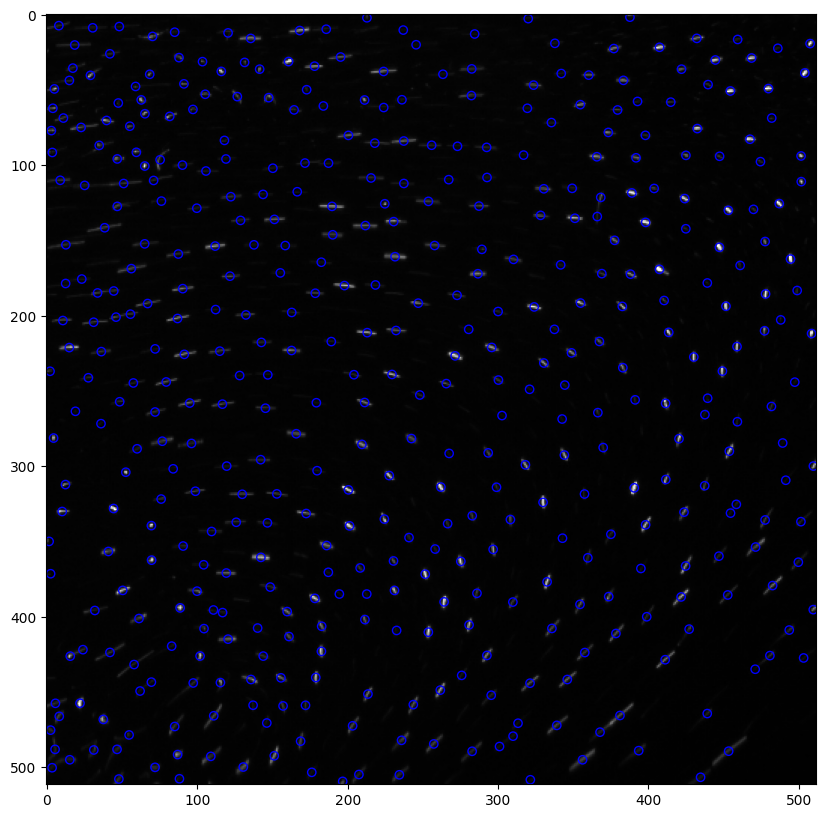

In [7]:
image_to_show = 450
img = np.array(Image.open(path+str(image_to_show)+".bmp"))/255
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="gray")
plt.scatter(np.load("positions/"+str(image_to_show)+".npy")[:, 0], np.load("positions/"+str(image_to_show)+".npy")[:, 1], facecolors='None',edgecolors='blue')
plt.show()

# SOM Variable Settings

In [8]:
folder = "positions/"
dmax = 8.96/image_size
alpha = 0.011
cycles = 5
startradius = 128 / image_size 
finalradius = 0.0128 / image_size
epsilon = 10.24/image_size 
plot = "yes" #"yes"/"no"
output = "matches" #"percentage"/"matches"/"no"
min_length = 3

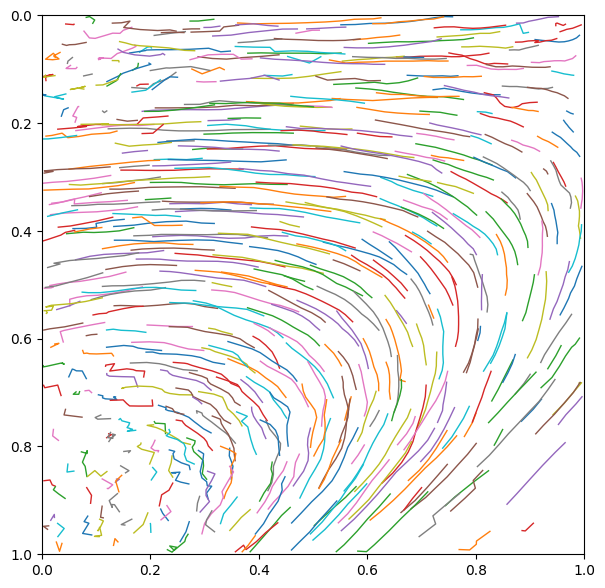

In [9]:
allmatches = []

for i in range(images_to_match-1):
    a = np.load(folder+str(i + starting_image)+".npy")
    b = np.load(folder+str(i + starting_image+1)+".npy")
    clear_output(wait=True)
    matches = SOMacc.som(a,b,cycles,startradius,finalradius,alpha,image_size,epsilon,plot,output,dmax)
    print("Finished image "+str(i+2)+"/"+str(images_to_match))
    allmatches.append(matches)
clear_output(wait=True)
coords = SOMacc.traces_to_coords(SOMacc.alltracing(allmatches,min_length),starting_image,image_size,folder)
SOMacc.plotting_coords(coords)

# Angular Velocity

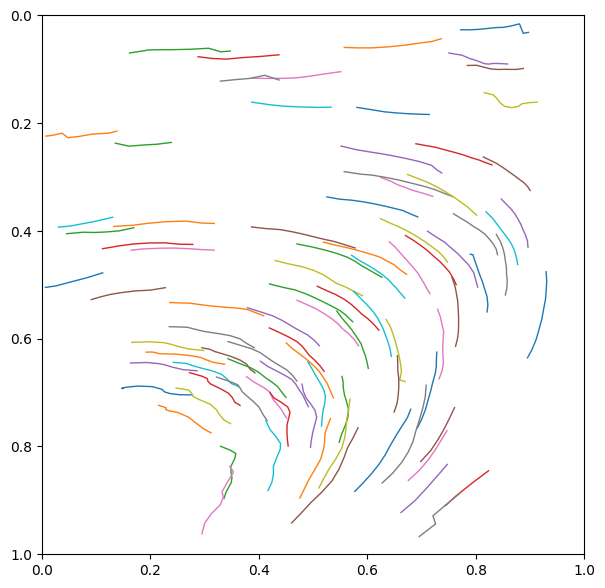

In [121]:
min_length_on_circle = 0.1
radius_filter = (0.05,0.8)

velocities = SOMacc.angular_velocity_all(coords,min_length_on_circle,radius_filter)
filtered = []
for velocity in velocities:
    filtered_coords = coords[velocity[1]]
    filtered.append(filtered_coords)
SOMacc.plotting_coords(filtered)

(266.25231017717607, 0.20397154410395704, 0.2633601626249872)

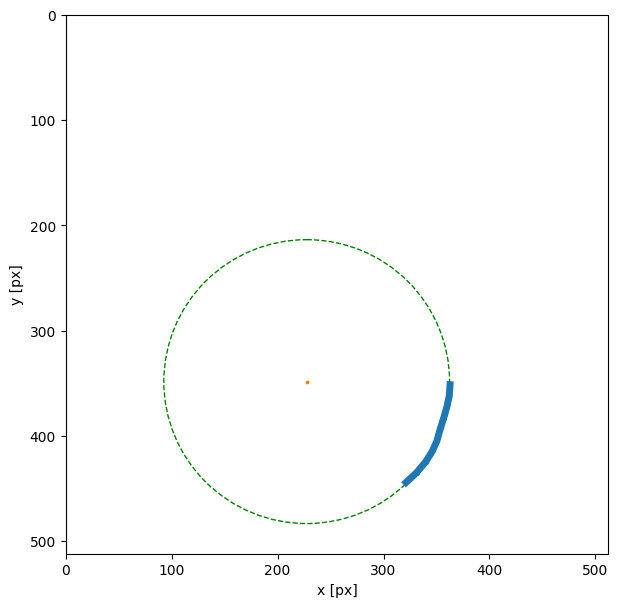

In [122]:
show = 77
SOMacc.angular_velocity_single(coords[velocities[show][1]],"yes") #Output= Anular Vel.[deg/s], arc length, radius

# PIV

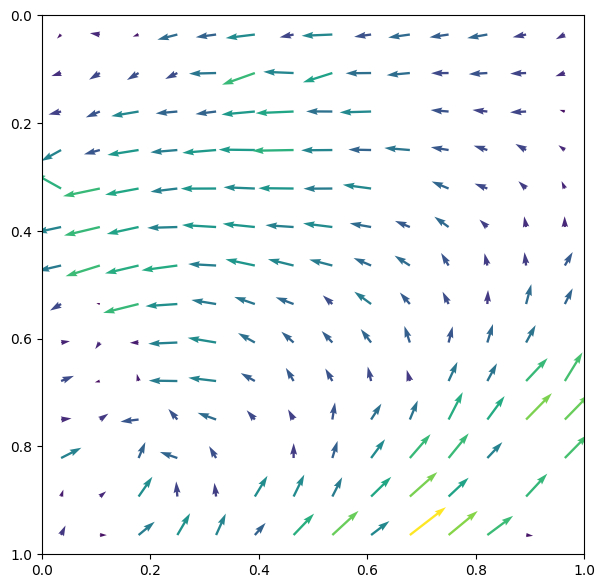

In [12]:
a = np.load(folder+str(starting_image)+".npy")
b = np.load(folder+str(starting_image+1)+".npy")
matches = SOMacc.som(a,b,cycles,startradius,finalradius,alpha,image_size,epsilon,"no",output,dmax)
SOMacc.coords_to_PIV(SOMacc.matches_to_coords(matches,starting_image,image_size,folder),boxes = 14,scale=None)

# Particle Velocites

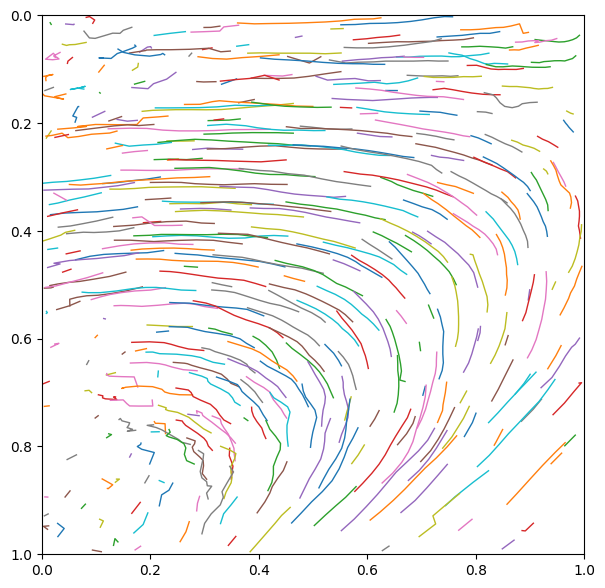

In [13]:
plot = "no"
min_length = 0
allmatches = []
for i in range(images_to_match-1):
    a = np.load(folder+str(i + starting_image)+".npy")
    b = np.load(folder+str(i + starting_image+1)+".npy")
    matches = SOMacc.som(a,b,cycles,startradius,finalradius,alpha,image_size,epsilon,plot,output,dmax)
    allmatches.append(matches)
coords = SOMacc.traces_to_coords(SOMacc.tracing(allmatches,min_length),starting_image,image_size,folder)
SOMacc.plotting_coords(coords)

In [14]:
#velocities calculated for 1 pair of images
fps = 60
velocities = []
for coord in coords:
    distance = math.sqrt((coord[1][0]-coord[0][0])**2+(coord[1][1]-coord[0][1])**2)*image_size
    velocity =distance / (1/fps) 
    velocities.append(velocity)
print("Mean velocity: "+str(np.mean(velocities)))
velocities #pixel per second

Mean velocity: 550.7409506281756


[457.0073013305006,
 442.0904884749282,
 111.8486553125195,
 217.51602961735003,
 31.095693411794578,
 512.8406576766363,
 839.9898980198905,
 509.21508225896065,
 688.0793954463896,
 888.0906829961062,
 569.0588522426223,
 299.1220145556583,
 220.98416232843473,
 565.9584855384177,
 369.7568367768143,
 542.5329255525796,
 318.21960785102675,
 554.8436855084461,
 633.6022701464174,
 680.025647853639,
 96.66666666666684,
 352.39414389722987,
 411.6246284183815,
 539.818799908538,
 83.35466393669888,
 541.5582319192986,
 407.04359033040373,
 224.22706745122855,
 901.7775932823217,
 477.6264143413516,
 130.2658978867806,
 1016.3273338025167,
 243.3404112875528,
 330.62772475751143,
 683.0274019021277,
 735.2635581884913,
 540.0003732630308,
 536.7393457622198,
 205.63079455334295,
 430.64167239132934,
 645.7776233158846,
 493.95529831624856,
 283.1981782484921,
 399.9034743056227,
 650.1037763311328,
 888.5129413454194,
 534.9882657072433,
 417.8059424607987,
 482.2588008739787,
 558.0780

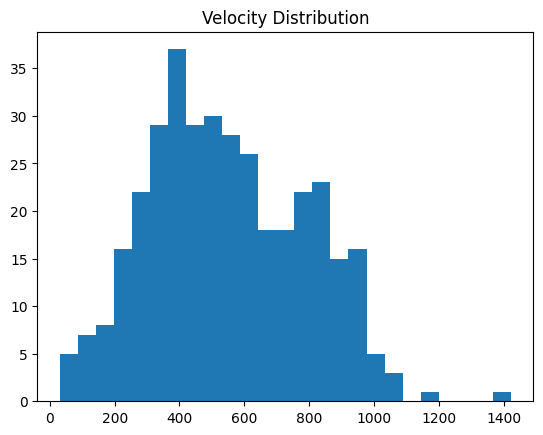

In [15]:
plt.hist(velocities,bins=25)
plt.title("Velocity Distribution")
plt.show()

In [16]:
#velocities calculated for whole trace
fps = 60
velocities = []
for coord in coords:
    trace_length=len(coord)-1
    distance = math.sqrt((coord[-1][0]-coord[0][0])**2+(coord[-1][1]-coord[0][1])**2)*image_size
    velocity = distance / (trace_length/fps) 
    velocities.append(velocity)
print("Mean velocity: "+str(np.mean(velocities)))
velocities #pixel per second

Mean velocity: 553.9139503787786


[704.3629301615367,
 902.2320772016487,
 111.8486553125195,
 167.3122482956704,
 236.00759898117582,
 449.2327253787797,
 678.8266019798838,
 388.04606849639674,
 688.0793954463896,
 888.080574215845,
 591.9215448958664,
 425.8736991178354,
 280.2035415396422,
 658.4722123948535,
 369.7568367768143,
 660.5572255937102,
 259.83847667495917,
 787.1363950508945,
 336.9662446002567,
 680.025647853639,
 276.60273009278956,
 329.17522162309257,
 480.0010416655364,
 539.818799908538,
 234.0939982143925,
 713.5134387911978,
 39.59970580143237,
 224.22706745122855,
 880.2650853570276,
 580.977580411422,
 443.28773087654815,
 916.9176391720217,
 281.63053579997865,
 218.7400791401113,
 701.4617714316621,
 936.7743191398874,
 551.8407289241786,
 745.4546068584663,
 254.3988203817327,
 375.49245031946214,
 782.1530675277597,
 493.95529831624856,
 401.9433211467981,
 396.81938586717246,
 659.6830567663651,
 846.40220770542,
 788.654356765018,
 573.3581389982666,
 538.018969638248,
 679.503589064119

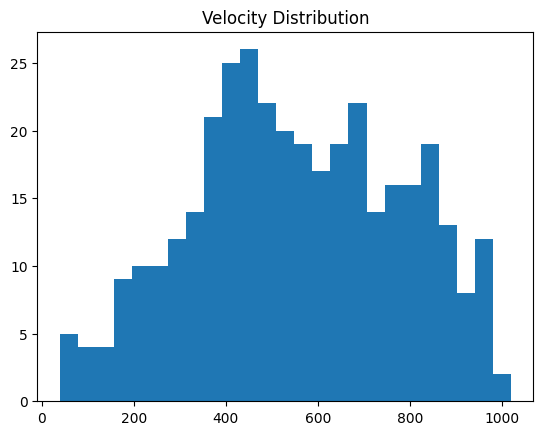

In [17]:
plt.hist(velocities,bins=25)
plt.title("Velocity Distribution")
plt.show()